### Notebook for extracting the most used AI techniques, AI usecases and Summaries from the datasets available on the following websites:
-   https://ai.gov/ai-use-cases/
-   https://www.hhs.gov/programs/topic-sites/ai/use-cases/index.html
#### This notebook extracts the most used AI techniques from both datasets, performs clustering to group the 430 contracts into 20 clusters, and then summarizes the combined text from each cluster using LLMs (BART, phi3, llama3). Finally, it performs topic labeling using the llama3 model.

#### Files needed to run the notebook:
        -- '2023 Consolidated AI Use Case Inventory (PUBLIC).csv'
        -- 'hhs-ai-use-cases-2023-public-inventory.csv'        
#### Files generated from the notebook:
        -- 'ai_use_case_topics.csv'
        -- 'summaries_of_usecases.csv'
        -- 'ai_use_cases_relevant_430.csv'        

#### Loading the two datasets to create two dataframes

In [1]:
import pandas as pd
import os
current_working_directory = os.getcwd()
csv_path_hhs = os.path.join(current_working_directory, "docs", "use_cases", "hhs-ai-use-cases-2023-public-inventory.csv")
csv_path_AI_inventory = os.path.join(current_working_directory, "docs", "use_cases","2023 Consolidated AI Use Case Inventory (PUBLIC).csv")
df_hhs = pd.read_csv(csv_path_hhs, encoding='latin1')
df_AI_inv = pd.read_csv(csv_path_AI_inventory, encoding='latin1')

In [2]:
print(df_hhs.shape)
df_hhs_trim=df_hhs[['Use Case Name', 'Agency', 'Bureau / Department', 'Summary of Use Case']].copy()
df_hhs_trim = df_hhs_trim.clean_names()

print(df_hhs_trim.columns)
rename_dict = {'summary_of_use_case': 'Summary','use_case_name': 'Title', 'agency':'Agency', 'bureau_department': 'Department'}
df_hhs_trim = df_hhs_trim.rename(columns=rename_dict)

(163, 12)
Index(['use_case_name', 'agency', 'bureau_department', 'summary_of_use_case'], dtype='object')


In [3]:
print(df_AI_inv.shape)
df_AI_inv_trim=df_AI_inv[['Title',  'Agency', 'Department_Code',  'Summary', 'Department', 'Techniques']].copy()
rename_dict = {'Department_Code': 'Department_code'}
df_AI_inv_trim = df_AI_inv_trim.rename(columns=rename_dict)
print(df_AI_inv_trim.columns)

(710, 10)
Index(['Title', 'Agency', 'Department_code', 'Summary', 'Department',
       'Techniques'],
      dtype='object')


#### Extract the department code from the text in the paranthesis

In [4]:
import re
def extract_or_return_same(text):
    match = re.search(r'\((.*?)\)', text)
    if match:
        return match.group(1)
    else:
        return text
    
df_hhs_trim['Department_code']=df_hhs_trim['Department'].apply(extract_or_return_same)

#### Exrtacting the mostly used AI techniques `hhs-ai-use-cases-2023-public-inventory.csv`

In [5]:
import itertools
techniques = df_AI_inv.Techniques.tolist()
techniques = [item.split(',') for item in techniques if isinstance(item, str)]
flattened_list = list(itertools.chain.from_iterable(techniques))
mostly_used_techniques=list(set(flattened_list))
print(len(mostly_used_techniques))

142


#### Text cleaning of the mostly used AI techniques

In [6]:
def split_and_flatten(strings):
    split_lists = [s.split(';') for s in strings]
    flattened_list_ = list(itertools.chain.from_iterable(split_lists))
    flattened_list_ = [item.strip() for item in flattened_list_]
    return flattened_list_

mostly_used_techniques_=split_and_flatten(mostly_used_techniques)
mostly_used_techniques_ = [s.replace('Unknown','').replace('.','').replace('#','').replace('&','and').replace('Â®','').replace('5)','5').replace(' (Nlp)','').strip().upper() for s in mostly_used_techniques_ if len(s)>1]
print(len(mostly_used_techniques_))

158


#### Below script processes a list by removing specified elements and mapping certain elements to new values using a dictionary. It then applies these transformations to clean and standardize the list of techniques.

In [7]:
def process_list(input_list, elements_to_remove, mapping_dict):
    # Remove specified elements
    filtered_list = [element for element in input_list if element not in elements_to_remove]
    # Map some elements to new values
    mapped_list = [mapping_dict.get(element, element) for element in filtered_list]
    # mapped_list=[s for s in mapped_list if s.contain('ML')]
    return list(set(mapped_list))

elements_to_remove = ['AT THIS TIME',
                    'OTHER',
                    'DOODLER: HTTPS://GITHUBCOM/DBUSCOMBE-USGS/DASH_DOODLER',
                    'PYTHON IN JUPYTER LABS',
                    'RANGE OF DATA DRIVEN', 
                    'DOCUMENT UNDERSTANDING',
                    'ACTIVE LEARNING',
                     'RETINANET',
                     'SUBJECTS WITH LONG-ARM RIFLES OR LARGE BACKPACKS AND TO EXCLUDE ITEMS OF LITTLE OR NO INTEREST SUCH AS ANIMALS',
                     'CONTINUOUS ACTIVE LEARNING'
                    ]

# Mapping dictionary
mapping_dict = {
    'NATURAL LANGUAGE PROCESSING (NLP)': 'NATURAL LANGUAGE PROCESSING',
    'NLP':'NATURAL LANGUAGE PROCESSING',
    'INTELLIGENT DOCUMENT RECOGNITION (IDR)': 'INTELLIGENT DOCUMENT RECOGNITION',
    'OPTICAL CHARACTER RECOGNITION (OCR)': 'OPTICAL CHARACTER RECOGNITION',
    'INTELLIGENT CHARACTER RECOGNITION (ICR)': 'INTELLIGENT CHARACTER RECOGNITION',
    'ROBOTIC PROCESS AUTOMATION (RPA)': 'ROBOTIC PROCESS AUTOMATION',
    'ROBOTIC PROCESSING AUTOMATION (RPA)': 'ROBOTIC PROCESS AUTOMATION',
    'THE MATROID SOFTWARE CURRENTLY PROCESSES AND ANNOTATES IMAGES USING PROPRIETARY SOFTWARE TO DETERMINE IF ANY OF THE IMAGES CONTAIN HUMAN SUBJECTS FUTURE USE CASES INCLUDE THE POTENTIAL TO DETECT ADDITIONAL ITEMS OF INTEREST SUCH AS VEHICLES': 'IMAGE PROCESSING',
    'ML': 'MACHINE LEARNING',
    'AI': 'ARTIFICIAL INTELLIGENCE',
    'XGBOOST ALGORITHM WITH PARAMETERS TUNED VIA RANDOM HYPERPARAMETER SEARCH USING 5-FOLD CROSS VALIDATION ON THE TRAINING DATASET FOR 60 ITERATIONS (RESULTING IN AT LEAST A 95% CHANCE OF FINDING A HYPERPARAMETER COMBINATION IN THE BEST 5% OF COMBINATIONS) THE SCORES RESULTING FROM THE XGBOOST ARE CALIBRATED VIA PLATT SCALING SO THAT MODEL SCORES CAN BE INTERPRETED AS DEFAULT PROBABILITIES THESE IS STANDARD METHOD FOR TRAINING CREDIT SCORING ALGORITHMS IN THE INDUSTRY':'MACHINE LEARNING',
    'MACHINE LANGUAGE LEARNING':'MACHINE LEARNING',
    'DOCUMENT/FILE CLASSIFICATION: DOCUMENT/FILE CLASSIFICATION IS A SUPERVISED ML ALGORITHM THAT CLASSIFIES WHOLE DOCUMENTS ACCORDING TO THEIR TYPE THE ALGORITHM WORKS BY CONVERTING EACH DOCUMENT TO A TERM FREQUENCYÂ\x80\x93INVERSE DOCUMENT FREQUENCY (TF-IDF) NUMERICAL REPRESENTATION AND PASSING THESE VECTORS THROUGH A MULTI-LAYER NEURAL NETWORK TO FINALLY GET THE DOCUMENTÂ\x80\x99S TYPE/CLASS DOCUMENT/FILE CLUSTERING: DOCUMENT/FILE CLUSTERING IS AN UNSUPERVISED ML ALGORITHM THAT GROUPS SIMILAR FILES TOGETHER ACCORDING TO THEIR CONTENT FOR EXAMPLE':'DOCUMENT/FILE CLASSIFICATION: NLP',
    'LONG SHORT TERM MEMORY (LSTM) MODELS':'RNN-LSTM',
    'LONG-SHORT TERM MEMORY BASED RECURRENT NEURAL NETWORKS':'RNN-LSTM',
    'ML VIA A CONVOLUTIONAL NEURAL NETWORK':'NEURAL NETWORKS',
    'MULTI-LAYER PERCEPTRON':'NEURAL NETWORKS',
    'YOLOV5':'COMPUTER VISION',
    'MACHINE VISION':'COMPUTER VISION',
    'NATURAL LANGUAGE PROCESSING (NLP) ALONG WITH SUPERVISED AND SELF-SUPERVISED MACHINE LEARNING VIA DEEP LEARNING MODELS':"NATURAL LANGAUGE PROCESSING, DEEP LEARING",
    "SUCH AS A RESIDUAL NEURAL NETWORK (RESNET) AND CONVOLUTIONAL NEURAL NETWORKS (CNN)":"RESNET AND CNN",
    'ARTIFICIAL NEURAL NETWORK': 'NEURAL NETWORKS',
    'NATURAL LANGUAGE PROCESSING FOR (A) DOCUMENT CLASSIFICATION AND (B) SENTENCE-LEVEL CAUSAL PASSAGE DETECTION': 'NLP CLASSIFICATION, SENTIMENT ANALYSIS',
    'STANDARD MACHINE LEARNING TO PREDICT VALUES FOR DESCRIPTIVE METADATA FIELDS GIVEN VARIOUS INPUTS SUCH AS THE CONTENT AND METADATA FROM THE RECORDS MANAGEMENT SYSTEM':'MACHINE LEARNING',
    '1 TEXTRACTION MACHINE LEARNING (ML) SERVICE WHICH USED OCR TO EXTRACT THE TEXT/DATA FROM SCANNED IMAGES 2 AUTOMATED NLP (NATURAL LANGUAGE PROCESSING) TO DETECT PII INFORMATION OUT OF THE EXTRACTED TEXT FROM SCANNED IMAGES': "NATURAL LANGUAGE PROCESSING, IMAGE PROCESSING",
    'ML (RECOMMENDER ALGORITHIM)': 'MACHINE LEARNING RECOMMENDER ALGORITHIM',
    'AI/ML TECHNIQUES':'MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE TECHNIQUES',
    'BAGGED TREES (AKA RANDOM FOREST) CLASSIFICATION':'RANDOM FOREST CLASSIFICATION',
    'AI/ML TECHNIQUES (EG RANDOM FORESTS)':'RANDOM FOREST',
    'AI/ML TECHNIQUES (EG LSTMS)':'LONG-SHORT TERM MEMORY',
    'OPTICAL MARK READING (OMR)':'OPTICAL MARK READING',
    'NON-DISCLOSURE AGREEMENTS WILL CLUSTER TOGETHER WHILE PRODUCT PRESENTATION FILES WILL BE ASSIGNED TO A DIFFERENT CLUSTER':'CLUSTERING'
     }

# Apply the function
mostly_used_techniques__ = process_list(mostly_used_techniques_, elements_to_remove, mapping_dict)
print(len(mostly_used_techniques__))


95


#### This script replaces specified substrings in a list of techniques with their corresponding values from a replacement dictionary, standardizing the terminology.

In [8]:
def replace_substrings(input_list, replacements):
    processed_list = []
    for item in input_list:
        for old, new in replacements.items():
            item = item.replace(old, new)
        processed_list.append(item)
    return processed_list

# Replacement dictionary
replacements = {
    'ML': 'MACHINE LEARNING',
    'DL': 'DEEP LEARNING',
    'CNN': 'CONVOLUTIONAL NEURAL NETWORKS',
    'NLP': 'NATURAL LANGUAGE PROCESSING',
    'LLM': 'LARGE LANGUAGE MODEL',
    'LSTM':'LONG-SHORT TERM MEMORY',
    'RNN':  'RECURRENT NEURAL NETWORKS',
    'UNET':'UNET CONVOLUTIONAL NEURAL NETWORKS',
    'U-NET':'UNET CONVOLUTIONAL NEURAL NETWORKS',
    'RESNET':'RESIDUAL NEURAL NETWORKS',
    'CHAT BOT': 'CHATBOT',
    'CHATBOTS': 'CHATBOT'
}

# Apply the function
processed_list = replace_substrings(mostly_used_techniques__, replacements)
processed_list

['MACHINE LEARNING',
 'RANDOM FOREST REGRESSION',
 'AI BASED VECTOR SEARCH OR CONTENT SIMILARITY SEARCH',
 'NATURAL LANGAUGE PROCESSING',
 'MACHINE LEARNING CLASSIFICATION',
 'LATENT DIRICHLET ALLOCATION',
 'RECURRENT NEURAL NETWORKS-LONG-SHORT TERM MEMORY',
 'NATURAL LANGUAGE PROCESSING, IMAGE PROCESSING',
 'REGRESSION AND RELATED METHODS',
 'IMAGE CLASSIFICATION USING JOINT UNSUPERVISED LEARNING (JULE)',
 'RECURRENT NEURAL NETWORKS',
 'API AUTOMATION',
 'NATURAL LANGUAGE PROCESSING',
 'MASK R-CONVOLUTIONAL NEURAL NETWORKS',
 'HIERARCHICAL GENERATIVE MODEL',
 'STOCHASTIC GRADIENT DECENT (LINEARLEARNER)',
 'TRANSFER LEARNING',
 'CONVOLUTIONAL NEURAL NETWORK',
 'REGRESSION',
 'RANDOM FOREST CLASSIFICATION',
 'CONVOLUTIONAL NEURAL NETWORKS (FASTERN-RCONVOLUTIONAL NEURAL NETWORKS',
 'FUZZY MATCHING',
 'CLOUD BASED COMMERCIAL-OFF-THE-SHELF PRE-TRAINED NATURAL LANGUAGE PROCESSING MODELS',
 'GRAPHICAL NEURAL NETWORK',
 'REINFORCEMENT LEARNING',
 'XGBOOST',
 'MANUAL LEARNING/NATURAL LANGUAGE'

In [9]:
new_column_order = ['Title', 'Agency', 'Department', 'Department_code','Summary']
df_hhs_trim=df_hhs_trim[new_column_order]
df_hhs_trim.head(1)

Title Agency             Department  \
0  Information Gateway OneReach Application    ACF  ACF Children's Bureau   

         Department_code                                            Summary  
0  ACF Children's Bureau  The Information Gateway hotline connects to a ...

In [10]:
new_column_order = ['Title', 'Agency', 'Department', 'Department_code', 'Techniques','Summary']
df_AI_inv_trim=df_AI_inv_trim[new_column_order]
df_AI_inv_trim.head(1)

Title                         Agency  \
0  AI Curated Synthetic Data  Customs and Border Protection   

                        Department Department_code  \
0  Department of Homeland Security             DHS   

                   Techniques  \
0  Synthetic Image Generation   

                                             Summary  
0  AI Curated Synthetic Data creates synthetic da...

In [11]:
def columns_to_dict(df, key_col, value_col):

    result_dict = {}
    for key, value in zip(df[key_col], df[value_col]):
        if key in result_dict:
            if value not in result_dict[key]:
                result_dict[key].append(value)
        else:
            result_dict[key] = [value]
    
    # Flatten lists with a single item
    result_dict = {k: v[0] if len(v) == 1 else v for k, v in result_dict.items()}
    
    return result_dict

# Convert the two columns into a dictionary
columns_to_dict(df_AI_inv_trim, 'Department', 'Department_code')

{'Department of Homeland Security': 'DHS',
 'Department of Commerce': 'DOC',
 'Department of Energy': 'DOE',
 'Department of Interior': 'DOI',
 'Department of Justice': 'DOJ',
 'Department of Labor': 'DOL',
 'Department of State': 'DOS',
 'Department of Transportation': 'DOT',
 'Department of Education': 'ED',
 'U.S. Environmental Protection Agency': 'EPA',
 'U.S. General Services Administration': 'GSA',
 'Department of Health and Human Services': 'HHS',
 'Department of Housing and Urban Development': 'HUD',
 'National Archives and Records Administration': 'NARA',
 'National Aeronautics and Space Administration': 'NASA',
 'U.S. Office of Personnel Management': 'OPM',
 'Social Security Administration': 'SSA',
 'Department of Treasury': 'TREAS',
 'U.S. Agency for International Development': 'USAID',
 'Department of Agriculture': 'USDA',
 'Department of Veterans Affairs': 'VA'}

#### Adding AI techniques found in other dataset

In [ ]:
processed_list=processed_list+['AI', 'CHATBOT', 'ML', 'NLP', 'dl', 'deep learning', 'CHATBOTS', 'machine-learning', 'cyberthreats', 'seq2seq', 'text summarization', 
                               'associated topics', 'data-driven', 'decision making', 'Long Short-Term Memory', 'lstm', 'recurrent neural network', 'Chat Bot',  'topic modeling', 'entity recognition', 
                               'Predictive Intelligence', 'decision-making', 'Zero-shot learning']

In [13]:
techniques_lower = [tech.lower() for tech in processed_list]
# Function to identify techniques in the summary
def identify_techniques(summary):
    found_techniques = []
    summary_lower = summary.lower()
    for tech in techniques_lower:
        if re.search(r'\b' + re.escape(tech) + r'\b', summary_lower):
            if tech not in found_techniques:
                found_techniques.append(tech)
    return ', '.join(found_techniques)
# Apply the function to each row in the DataFrame
df_hhs_trim['Techniques'] = df_hhs_trim['Summary'].apply(identify_techniques)

# Display the DataFrame with the new column
# df_hhs_trim[['Summary', 'Techniques']]

In [14]:
new_column_order = ['Title', 'Agency', 'Department', 'Department_code', 'Techniques','Summary']
df_hhs_trim=df_hhs_trim[new_column_order]

In [15]:
df_hhs_trim.head(1)

Title Agency             Department  \
0  Information Gateway OneReach Application    ACF  ACF Children's Bureau   

         Department_code                       Techniques  \
0  ACF Children's Bureau  natural language processing, ai   

                                             Summary  
0  The Information Gateway hotline connects to a ...

In [16]:
df_AI_inv_trim[df_AI_inv_trim['Techniques'].isna()].head(1)

Title                                    Agency  \
41  B2B Matchmaking  International Trade Administration (ITA)   

                Department Department_code Techniques  \
41  Department of Commerce             DOC        NaN   

                                              Summary  
41  The system's algorithms and AI technology qual...

In [17]:
for index, row in df_AI_inv_trim.iterrows():
    if pd.isna(row['Techniques']):
        df_AI_inv_trim.at[index, 'Techniques'] = identify_techniques(row['Summary'])

In [18]:
df_AI_inv_trim[['Techniques', 'Summary']].iloc[41]

Techniques                                                   ai
Summary       The system's algorithms and AI technology qual...
Name: 41, dtype: object

#### Combining the two datasets and filter the rows based on the departments of intrest

In [19]:
ai_use_cases=pd.concat([df_hhs_trim,df_AI_inv_trim], axis=0,ignore_index=True)
ai_use_cases.shape
ai_use_cases['Department_code']=ai_use_cases['Department_code'].str.upper()
relevant_agencies = ["HHS", "USDA", "ED", "DOE", "HUD", "SSA", "SBA", "VA"]
ai_use_cases_relevant=ai_use_cases[ai_use_cases['Department_code'].isin(relevant_agencies)]

#### Saving the dataset containing 430 use cases to a csv file

In [56]:
ai_use_cases_relevant.to_csv('ai_use_cases_relevant_430.csv')

In [20]:
def split_and_flatten(strings):
    split_lists = [s.split(',') for s in strings]
    flattened_list_ = list(itertools.chain.from_iterable(split_lists))
    flattened_list_ = [item.strip().upper() for item in flattened_list_ if item != '' ]
    return flattened_list_

techniques_relavant=ai_use_cases_relevant['Techniques'].tolist()
# techniques_relavant=list(set(techniques_relavant))
techniques_relavant=list(set(split_and_flatten(techniques_relavant)))

In [21]:
mostly_used_techniques_relavant = process_list(techniques_relavant, elements_to_remove, mapping_dict)
print(len(mostly_used_techniques_relavant))

45


#### AI techniques used in the 430 AI use cases

In [22]:
techniques_used = replace_substrings(mostly_used_techniques_relavant, replacements)
list(set(techniques_used))

['K-MEANS CLUSTERING',
 'FUZZY MATCHING',
 'OBJECT DETECTION',
 'DATA-DRIVEN',
 'TOPIC MODELING',
 'MACHINE LEARNING CLASSIFICATION',
 'MACHINE LEARNING',
 'REINFORCEMENT LEARNING',
 'XGBOOST',
 'LONG-SHORT TERM MEMORY',
 'CLUSTERING',
 'BIG DATA',
 'ARTIFICIAL INTELLIGENCE UNKNOWN',
 'CYBERTHREATS',
 'LONG SHORT-TERM MEMORY',
 'VISUAL ANALYSIS',
 'ASSOCIATED TOPICS',
 'TEXT SUMMARIZATION',
 'PREDICTIVE INTELLIGENCE',
 'SEQ2SEQ',
 'NOVEL SPECTROSCOPIC TECHNOLOGY',
 'RECURRENT NEURAL NETWORK',
 'DECISION MAKING',
 'NATURAL LANGUAGE PROCESSING',
 'HIERARCHICAL GENERATIVE MODEL',
 'MACHINE-LEARNING',
 'ENTITY RECOGNITION',
 'COMPUTER VISION',
 'ROBOTIC PROCESS AUTOMATION',
 'ARTIFICIAL INTELLIGENCE',
 'DEEP LEARNING',
 'VIRTUAL ASSISTANT',
 'RANDOM FOREST',
 'TRANSFER LEARNING',
 'CHATBOT',
 'NEURAL NETWORKS',
 'REGRESSION',
 'VISUALIZATION',
 'LOGISTIC REGRESSION',
 'CLASSIFICATION',
 'DECISION-MAKING',
 'ZERO-SHOT LEARNING']

#### Saving the AI techniques to text file

In [57]:
file_name = "AI_echniques_used.txt"
# Open the file in write mode and save the list
with open(file_name, "w") as file:
    for item in techniques_used:
        file.write(item + "\n")

In [24]:
ai_use_cases_relevant['Techniques']=ai_use_cases_relevant['Techniques'].apply(lambda x: x.upper())

C:\Users\sankar.kalaga\AppData\Local\Temp\ipykernel_16156\1133879325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_use_cases_relevant['Techniques']=ai_use_cases_relevant['Techniques'].apply(lambda x: x.upper())


#### clustering the similar use cases followed by preprocessing the summaries of the use cases

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# # Download necessary NLTK packages for tokenization and stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing
ai_use_cases_relevant['Processed_Summary'] = ai_use_cases_relevant['Summary'].apply(preprocess_text)

# Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(ai_use_cases_relevant['Processed_Summary'])

# Similarity Calculation
similarity_matrix = cosine_similarity(tfidf_matrix)

num_clusters = 20  
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_

# Assign clusters back to the DataFrame
ai_use_cases_relevant['Cluster'] = clusters

#### Plotting the elbow plot

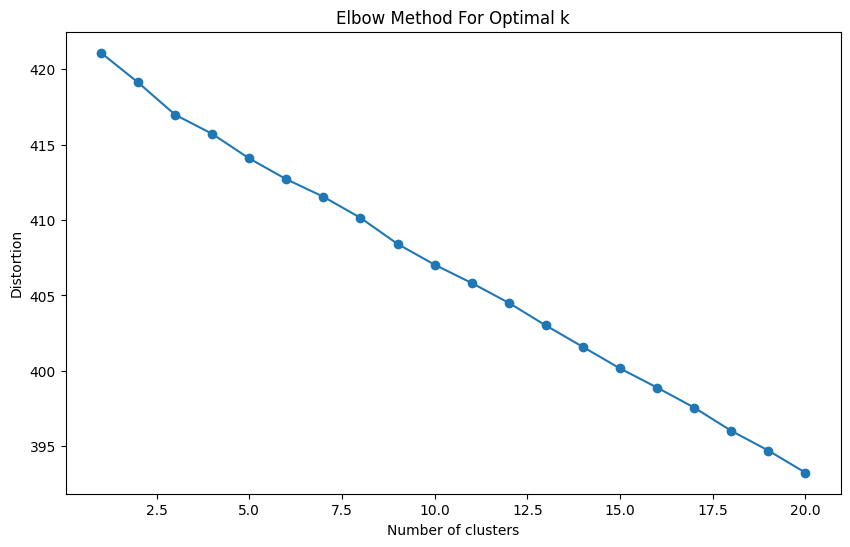

In [27]:
import matplotlib.pyplot as plt

# Function to calculate the distortions for different numbers of clusters
def calculate_distortions(data, max_clusters):
    distortions = []
    for i in range(1, max_clusters + 1):
        km = KMeans(n_clusters=i, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

distortions = calculate_distortions(tfidf_matrix, num_clusters)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_clusters+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()


#### Print contents of first few clusters

In [28]:
def print_cluster_contents(cluster_id, num_samples=5):
    print(f"\nCluster - {cluster_id}:")
    samples = ai_use_cases_relevant[ai_use_cases_relevant['Cluster'] == cluster_id]['Summary'].sample(n=num_samples, random_state=1)
    for i, sample in enumerate(samples, 1):
        print(f"Sample {i}: {sample}")

for i in range(min(num_clusters, num_clusters)):  
    print_cluster_contents(i)


Cluster - 0:
Sample 1: Computation of the descriptors (atomic property-weighted radial 
distribution functions) that will be used for the ML portion of the task; 
Fitting of a machine-learned model for the prediction of B sorption; 
Optimization and computational design of a sorbent for maximum 
sorption of B as a function of B concentration in the aqueous solution; 
Force field generation for an additional pollutant (if needed); Sorption 
calculations and ML fitting for the second pollutant (TBD); Optimization 
and computational design of a sorbent for maximum sorption of the 
second pollutant as a function of pollutant concentration in the aqueous 
solution.
Sample 2: Will leverage state-of-the-art, physics-based deep learning (DL) models 
to learn generalizable surrogates that may be used in place of CFD 
models to predict quantities required for downstream optimization. The 
products from this subtask can be immediately leveraged by other 
subtasks that are seeking to speed up the

#### Concatinating the summaries in each cluster

In [29]:
clustered_texts = ai_use_cases_relevant.groupby('Cluster')['Summary'].apply(' '.join)
pd.set_option('display.max_colwidth', 2000)
print(clustered_texts)

Cluster
0     Model architecture development research, including workflows, \nalgorithm and performance optimization Machine learning and quantum computing applied towards optimization, \nquantum chemistry, material science, and cryptography Computation of the descriptors (atomic property-weighted radial \ndistribution functions) that will be used for the ML portion of the task; \nFitting of a machine-learned model for the prediction of B sorption; \nOptimization and computational design of a sorbent for maximum \nsorption of B as a function of B concentration in the aqueous solution; \nForce field generation for an additional pollutant (if needed); Sorption \ncalculations and ML fitting for the second pollutant (TBD); Optimization \nand computational design of a sorbent for maximum sorption of the \nsecond pollutant as a function of pollutant concentration in the aqueous \nsolution. Will leverage state-of-the-art, physics-based deep learning (DL) models \nto learn generalizable surrog

#### Summary generation using the HugginFace's BART model

In [30]:
from transformers import BartForConditionalGeneration, BartTokenizer

def abstractive_summary(text, model, tokenizer, max_length=1024, num_beams=4):
    inputs = tokenizer("summarize: " +text, max_length=max_length, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=num_beams, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Load pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Apply abstractive summarization on each cluster
abstractive_summaries_bart = clustered_texts.apply(lambda x: abstractive_summary(x, model, tokenizer))
print(abstractive_summaries_bart)


c:\Users\sankar.kalaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cluster
0                                                                                                                                                                                              Machine learning and quantum computing applied towards optimization, material science, and cryptography. Will leverage state-of-the-art, physics-based deep learning (DL) models. Will learn generalizable surrogates that may be used in place of CFD models to predict quantities required for downstream optimization.
1                                                                                                                                                                   Machine learning models were developed to predict CO2 permeability and CO2/N2 selectivity of polymers. AI/ML will be used to recognice patterns in well integrity records that could predict failure events. Use multisource machine learning to model soil moisture within a disposal cell. Wearable device and AI model to predic

#### Summary generation by the phi3 model using ollama api

In [32]:
import ollama

def gen_title_phi3(text: str):
    response = ollama.chat(model='phi3', messages=[
        {"role" : "system", "content" : "You are a Summary generator. Generate a summary from the provided text."},
        {"role" : "user", "content" : "Convert the following text into a summary of the form 'Summary: <summary>':"},
        {"role" : "user",  "content" : text}
    ])
    title = response['message']['content']
    return title


abstractive_summaries_phi3 = clustered_texts.apply(lambda x: gen_title_phi3(x))
print(abstractive_summaries_phi3)


Cluster
0                                                        Summary: The project aims to optimize the design, processing, and validation of an integrated BC-EBC-TBC system using laser manufacturing techniques while considering its application in hydrogen turbines with SiCf/SiC matrix CMCs as next-gener03 \nn generation propulsion systems. Extensive experimental data is expected to provide valuable insights into RDC design, model validation and development of advanced combustion sensors using AI and computer vision technologies. Simultaneously efforts are being made to develop ML models that can act as surrogates for complex unit operations or multi-scale bridging in IDAES optimization framework with real scale problem focused on carbon capture process, MIP solver tuning through machine learning methods have been proposed while simultaneously validating CFD models of the MHD channel system using dual gaps obtained from different branching strategies. Implementations will be carried

#### Summary generation by the llama3 model using ollama api

In [33]:
import ollama

def gen_summaries_llama3(text: str):
    response = ollama.chat(model='llama3', messages=[
        {"role" : "system", "content" : "You are a Summary generator. Generate a summary from the provided text."},
        {"role" : "user", "content" : "Convert the following text into a summary of the form 'Summary: <summary>':"},
        {"role" : "user",  "content" : text}
    ])
    title = response['message']['content']
    return title

abstractive_summaries_llama3 = clustered_texts.apply(lambda x: gen_summaries_llama3(x))
print(abstractive_summaries_llama3)

Cluster
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#### Saving the clustered text, summaried by BART, phi3 and llama3 models to a csv file

In [48]:
df_summaries = pd.concat([clustered_texts, abstractive_summaries_bart, abstractive_summaries_phi3, abstractive_summaries_llama3], axis=1)
df_summaries.columns=['clustered_summaries','BART_summaries','phi3_summaries','llama3_summaries']
df_summaries.to_csv('summaries_of_usecases.csv')

#### Reading the dataset containing 430 use cases to a csv file for topic identification

In [8]:
df_topics=pd.read_csv('ai_use_cases_relevant_430.csv', index_col='Unnamed: 0')
df_topics.head()

Title  \
253  Automated sorting of high repetition rate cohe...   
254  Machine Learning for Autonomous Control of Sci...   
255                                               SMMM   
256                                       AI Denoising   
257                Extreme data reduction for the edge   

                             Agency            Department Department_code  \
253  Brookhaven National Laboratory  Department of Energy             DOE   
254  Brookhaven National Laboratory  Department of Energy             DOE   
255  Brookhaven National Laboratory  Department of Energy             DOE   
256      Fermi National Accelerator  Department of Energy             DOE   
257      Fermi National Accelerator  Department of Energy             DOE   

                                            Techniques  \
253                                                NaN   
254                                                 ML   
255                                             AI, ML   
256  ARTIFICIAL INTELLIGENCE, BIG DATA, NEURAL NETW...   
257  ARTIFICIAL INTELLIGENCE, BIG DATA, NEURAL NETW...   

                                               Summary  \
253  "Coherent X-rays are routinely provided today ...   
254  BNL will work alongside SLAC, to implement ML ...   
255  AI/ML is being used to evaluate measurements i...   
256  This program aims to develop generative models...   
257  This projects develops AI algorithms and tools...   

                                     Processed_Summary  Cluster  
253  coherent routinely provided today latest synch...        7  
254  bnl work alongside slac implement ml algorithm...        8  
255  used evaluate measurements simultaneous experi...       16  
256  program aims develop generative models quickly...       16  
257  projects develops ai algorithms tools data red...       16

#### Function to identify the topics using llama3 model using ollama API

In [9]:
import ollama

def gen_topic_llama3(text: str):
    response = ollama.chat(model='llama3', messages=[
        {"role" : "system", "content" : "You are a topic labeller, I want you to identiy the topic for given text from the list of topics given below?, note just give me the topic name and limit your answer to two tokens"},
        {"role" : "user", "content" : """
                                        Topics:
                                    	1.	Accessibility: using AI for translation / interpretation, section 508 compliance, plain language, or other activities to increase accessibility of documents and interactions with the government
	                                    2.	Policy-making and public engagement: use of AI in any stage of developing regulations or gathering input
                                        3.	Asset management: use of AI to manage both physical and digital assets
                                        4.	Hotlines and service desks: use of AI to triage, respond, and refer to calls, texts, emails
                                        5.	Service / benefits access: use of AI to support determining eligibility for services, streamlining applications, etc.
                                        6.	Program integrity: use of AI to detect potential fraud or other wrong-doing in use of public benefits and services
                                        7.	Case management: use of AI to document and summarize interactions, suggest and enable referrals
                                        8.	Service delivery: use of AI to provide direct services either to the public or to state/local/tribal/territorial governments 
                                        9.	People operations: use of AI for purposes related to recruiting, retaining, and off-boarding employees
                                        10.	Internal operations: administrative use cases for AI, e.g. notetaking, virtual assistants
                                        11.	Other
                                    Identify the topic the text belongs to '<topic_name>':"""},
        {"role" : "user",  "content" : text}
    ])
    Topic = response['message']['content']
    return Topic


In [10]:
gen_topic_llama3(df_topics['Summary'].tolist()[0])

'Internal operations: administrative use cases for AI, e.g. notetaking, virtual assistants'

In [ ]:
# Applying function on the summary column to identify the topics using llama3 model 
df_topics['topics']=df_topics['Summary'].apply(lambda x:  gen_topic_llama3(x))

In [ ]:
# saving the topics to the csv file
df_topics.to_csv('ai_use_case_topics.csv')